# Handwritten digit classification via transfer learning

... to decode the MNIST 784 dataset. This dataset contains a subset of 70,000 size-normalized and centered hand written digits. Previously a convolutional neural network was built with 99.6% accuracy.

...

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
import os
import pickle

In [46]:
os.chdir('C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\MNIST784_transfer_learning')
os.getcwd()

'C:\\Users\\corne\\OneDrive\\Documents\\DS_Portfolio\\MNIST784_transfer_learning'

In [47]:
#fully connected training iterations
fc_iter = 1

#fine tuning traiing iterations
ft_iter = 1

iters = (fc_iter, ft_iter)

### Preprocessing data

In [48]:
#Loading MNIST_784 dataset from OpenML
mnist = fetch_openml('mnist_784', as_frame = False, parser='auto') 
X,y = mnist.data.reshape(-1,28,28,1), mnist.target.reshape(-1,1)
y = y.astype(np.int64)

In [49]:
#rescaling X
print('X range before rescaling:')
print(round(X[0].min(),2), round(X[0].max(),2))

X = X/127.5-1
print('X range after rescaling')
print(round(X[0].min(),2), round(X[0].max(),2))
print(f'X mean: {round(X.mean(),2)}')
print(f' X std: {round(X.std(),2)}')


X range before rescaling:
0 255
X range after rescaling
-1.0 1.0
X mean: -0.74
 X std: 0.62


In [50]:
#Defining function to look at a digit
def show_num(input_pic):
  plt.imshow(input_pic,cmap='binary')
  plt.axis(False)

Image shape before:
(70000, 28, 28, 1)
Image shape after:
(70000, 28, 28, 3)

Checking Image:


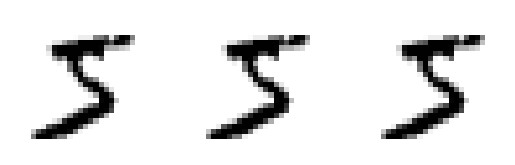

In [51]:
#repeating gray scale image in 3 channel format for compatability with three channel format 
#of the pre-trained network

print('Image shape before:')
print(X.shape)  
X_rgb = np.repeat(X,3,axis=-1)
print('Image shape after:')
print(X_rgb.shape)

print('\nChecking Image:')
#checking repeat image 
for n in range(3):
    ax = plt.subplot(1,3,n+1)
    show_num(X_rgb[0][:,:,n])

In [52]:
#Making test and train sets
X_train, y_train, X_valid, y_valid, X_test, y_test = X_rgb[:60000], y[:60000],X_rgb[60000:65000],y[60000:65000],X_rgb[65000:],y[65000:]

#temporary 
X_train = X_train[:5000]
y_train = y_train[:5000]
X_valid = X_valid[:1000]
y_valid = y_valid[:1000]


train_data = (X_train, y_train, X_valid, y_valid)

### Building and training transfer learning models

In [53]:
#function for creating transfer learning model

def build(t_model, input_size):
    #creates transfer model
    transfer_model = t_model(include_top=False, input_shape=(input_size,input_size,3),weights='imagenet')
    transfer_model.trainable = False #freezes model 
    #note: setting trainable to false also sets training to false for BN layers in tf version 2.0 and above

    #creates model with fully connected layers
    print('Building model...')
    inputs = tf.keras.Input(shape=(28,28,3), name='Input')
    x = tf.keras.layers.Resizing(input_size, input_size)(inputs)
    x = transfer_model(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(units=10,activation='linear',kernel_initializer='he_normal')(x)
    model = tf.keras.Model(inputs, outputs)

    print(model.summary())

    
    #compile model 
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.Adam(0.001),
            metrics = ['accuracy'])
    

    return(model)

In [54]:
def train_FC(model, train_data, iters):
    #training top layers
    print('Training top layers...')
    history = model.fit(train_data[0], train_data[1], validation_data=(train_data[2:]), epochs = iters[0])

    #saving weights
    weight_name = 'weights_'+str(model.layers[2].name)+'_fc.h5'
    model.save_weights(weight_name)
    return(model, history)
    #save_weights = ModelCheckpoint(weight_file_name, save_best_only=True, save_weights_only=True)

In [55]:
def fine_tune(model, train_data, iters):
    print('Fine tuning all layers...')
    
    #unfreezing transfer model
    model.layers[2].trainable = True 
    #print(str(model.layers[2].name),str(model.layers[2].trainable))

    #Checking that BN layers are in inference mode and all layers are trainable
    for layer in model.layers[2].layers: 
        if (isinstance(layer, tf.keras.layers.BatchNormalization)):
            layer.trainable = False
        else: assert layer.trainable == True

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(1e-6),
        metrics = ['accuracy'])

    history = model.fit(train_data[0], train_data[1], validation_data = (train_data[2:]), epochs = iters[1])

    #saving weights
    weight_name = 'weights_'+str(model.layers[2].name)+'_ft.h5'
    model.save_weights(weight_name)

    return(model, history)

In [56]:
def build_and_train(t_model, input_size, train_data, iters):
    model = build(t_model, input_size)

    model, history = train_FC(model, train_data, iters)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    model, history = fine_tune(model, train_data, iters)
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

    scores = (acc, val_acc, loss, val_loss)
    #pickles scores
    pickle_name = str(t_model)+('_scores.pkl')
    pickle.dump(scores, open(pickle_name, 'wb'))

    return(model,scores)
    

In [57]:
def predict(model, test_data):
    y_pred = model.predict(test_data[0]).argmax(axis=1)
    return accuracy_score(test_data[1],y_pred)

## Models

In [58]:
resnet_model, resnet_score = build_and_train(ResNet50,32,train_data,iters)

Building model...
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_3 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               262272    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)  

In [59]:
inception_model, inception_score = build_and_train(InceptionV3,75,train_data,iters)

Building model...
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_4 (Resizing)       (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)  

In [60]:
mobilenet_model, mobilenet_score = build_and_train(MobileNet,32,train_data,iters)

Building model...
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 3)]       0         
                                                                 
 resizing_5 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 128)               131200    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                         

### Model Performance

NameError: name 'acc' is not defined

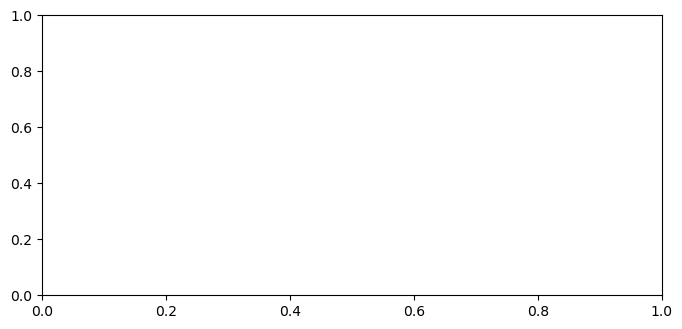

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([fc_iter-1,fc_iter-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([fc_iter-1,fc_iter-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)
resnet_score = accuracy_score(y_test,y_pred)